In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import string
from collections import defaultdict
#nltk.download('punkt')
%matplotlib inline

In [2]:
def get_training_data(train_path):
    print('Reading Training data')
    df_train=pd.read_csv(train_path,delimiter='\t',names=["Disease", "PatientReport"])
    return df_train

def get_test_data(test_path):
    print('Reading Test data')
    df_test=pd.read_csv(test_path,delimiter='\t',names=["PatientReport"])
    return df_test

In [3]:
import re
def get_clean_data(df):
    print('removing stop words')
    stop_words = set(stopwords.words('english'))
    df['tokens']=df['PatientReport'].apply(wordpunct_tokenize)
    #pattern = '[0-9]'
    #list = [re.sub(pattern, '', i) for i in list]
    #change these too one if statement or conditions--------------------------
    df['stop']=df['tokens'].apply(lambda x: [item for item in x if item not in stop_words])
    df['alphum']=df['stop'].apply(lambda word: [e for e in word if(e.isalpha())])
    df['report']=df['alphum'].apply(lambda word:[w for w in word if len(w)>3])
    df.drop(['tokens','PatientReport','stop','alphum'],axis=1,inplace=True)
    return df

def stem_data(df):
    print('Stemming words')
    stemmer = PorterStemmer()
    df['stemmed']=df['report'].apply(lambda word:[stemmer.stem(w) for w in word])
    df.drop(['report'],axis=1,inplace=True)
    return df

def get_vectors(df,train=True):
    print('get vectors')
    #data = np.array(['i am a test sentence','being tested in idf vectorizer']) 
    #series=pd.Series(data)
    df['raw']=df["stemmed"].str.join(" ")
    cv=CountVectorizer()
    word_count_vector=cv.fit_transform(df['raw'])
    
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    
    count_vector=cv.transform(df['raw'])
    mat=tfidf_transformer.transform(count_vector)
    return mat

def csr_l2normalize(mat, copy=True, **kargs):
    r""" Normalize the rows of a CSR matrix by their L-2 norm. 
    If copy is True, returns a copy of the normalized matrix.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # normalize
    for i in range(nrows):
        rsum = 0.0    
        for j in range(ptr[i], ptr[i+1]):
            rsum += val[j]**2
        if rsum == 0.0:
            continue  # do not normalize empty rows
        rsum = 1.0/np.sqrt(rsum)
        for j in range(ptr[i], ptr[i+1]):
            val[j] *= rsum
            
    if copy is True:
        return mat

In [10]:
from scipy.sparse.linalg import norm
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

class Custom_KNN_Classifier:
   
    def fit(self,train_mat,labels,k):
        self.train_mat=train_mat
        self.labels=labels.tolist()
        self.k=k
        
    def get_pairwise_cosine_similarity(self,test_mat):
        return self.train_mat.dot(test_mat.T)
    
    def transform(self,X_test):
        '''
        For each sample in test,
        1. Get similarities
        2. Sort the similarities(Desc)
        3. Choose top K vectors,labels
        4. vote for final labels
        '''
        
        # Calculating similarity between train set and Test set.
        pairwise_sim_matrix=self.get_pairwise_cosine_similarity(X_test)
        
        sim_df=pd.DataFrame(pairwise_sim_matrix.todense())
        sim_df['labels']=self.labels
        
        predictions=[]
        for d in range(X_test.shape[0]):
            new_df=sim_df[[d,'labels']].sort_values(by=[d],ascending=False).head(self.k)
            candidate_labels=new_df['labels']
            predictions.append(self.vote_for_labels(candidate_labels))
        return predictions
    
    def vote_for_labels(self,candidate_labels):
        
        class_counter = Counter()
        for label in candidate_labels:
            class_counter[label] += 1
        return class_counter.most_common(1)[0][0]

In [5]:
#-------Train Data---------------
train_path="train.dat"
train_df=get_training_data(train_path)
labels=train_df['Disease']
    
train_df=get_clean_data(train_df)    
train_df=stem_data(train_df)

train_df['raw']=train_df["stemmed"].str.join(" ")
cv=CountVectorizer()
word_count_vector=cv.fit_transform(train_df['raw'])
    
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
    
#count_vector=cv.transform(df['raw'])
train_df_tfidf=tfidf_transformer.transform(word_count_vector)
train_df_normalized=csr_l2normalize(train_df_tfidf)



Reading Training data
removing stop words
Stemming words


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(train_df_normalized,labels, test_size=0.2,random_state=11)  
classifier=Custom_KNN_Classifier()
classifier.fit(X_train,y_train,3)
predictions=classifier.transform(X_test)

from sklearn.metrics import f1_score
f1_score(y_test,predictions,average='weighted')


0.46987047960522765

In [12]:
error_rate=[]
for i in range(1,110):
    knn=Custom_KNN_Classifier()
    knn.fit(X_train,y_train,i)
    pred_i=knn.transform(X_test)
    error_rate.append(np.mean(pred_i!=y_test))


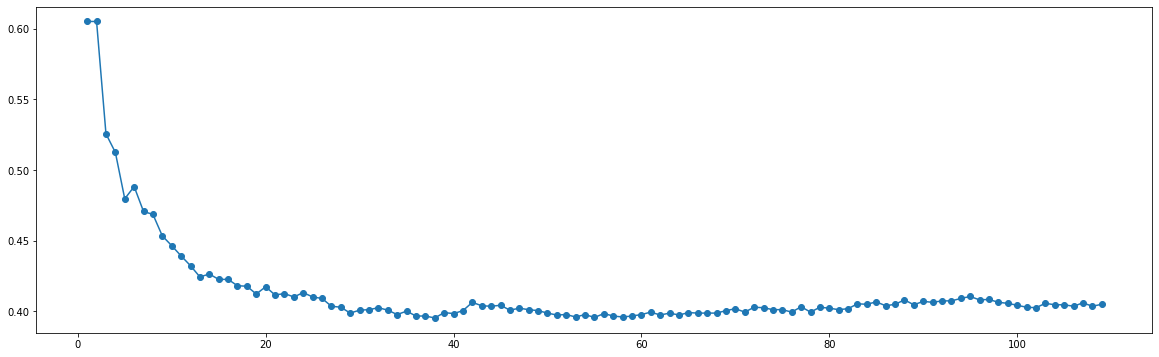

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[20,6])
plt.plot(range(1,110),error_rate,marker='o')

In [ ]:
#-------test data--------------

classifier=Custom_KNN_Classifier()
classifier.fit(train_df_normalized,labels,3)

#test_path="B:\\Studies\\Datasets\\Program\\test.txt"
test_path="test.dat"
#output_path="output_path=B:\MS_SCU\Winter20\DataMiningAndPatterRecognition\Assignments\Programs\out.txt"
output_path="format.dat"
test_df=get_test_data(test_path)
test_df=get_clean_data(test_df)    
test_df=stem_data(test_df)
test_df['raw']=test_df["stemmed"].str.join(" ")
test_df_cv=cv.transform(test_df['raw'])
test_df_tfidf=tfidf_transformer.transform(test_df_cv)
test_df_normalized=csr_l2normalize(test_df_tfidf)

predictions=classifier.transform(test_df_normalized)

In [ ]:
with open(output_path, 'w') as filehandle:
    filehandle.writelines("%s\n" % label for label in predictions)